In [1]:
plotpars = {'axes.labelsize': 18,
            'axes.linewidth': 1.,
            'figure.figsize': (7.,5.),
            'font.size': 12,
            'legend.frameon': True,
            'legend.framealpha': 0.85,
            'legend.edgecolor': 'black',
            'legend.loc': 'best',
            'legend.fontsize': 12,
            'mathtext.fontset': 'stixsans',
            'savefig.bbox': 'tight',
            'xtick.labelsize': 18,
            'ytick.labelsize': 18,
           }

# Libraries

In [2]:
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt
import matplotlib         as mt
import seaborn            as sns
from matplotlib.gridspec  import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology    import FlatLambdaCDM

In [3]:
# %matplotlib notebook

# Loading Dataset

In [4]:
my_data = np.loadtxt('../../Catalogue/Match07_smalldoubleclean_emlines.csv', delimiter=',', dtype=str)

In [5]:
my_dictionary = {}
for i in range(len(my_data[0, :])):                                         # Converting numpy array into dictionary
    my_dictionary[my_data[0, i]] = np.array(my_data[0 + 1:, i], dtype=str)

In [7]:
print (my_data.shape)
print (my_data.size)
print (my_data[0,:])

(14332, 164)
2350448
['CATAID' 'OBJID_SDSSDR7' 'ALPHA_J2000' 'DELTA_J2000' 'KRON_RADIUS'
 'PETRO_RADIUS' 'MAG_PETRO_u' 'MAGERR_PETRO_u' 'FLAGS_u' 'MAG_PETRO_g'
 'MAGERR_PETRO_g' 'FLAGS_g' 'MAG_PETRO_r' 'MAGERR_PETRO_r' 'FLAGS_r'
 'MAG_PETRO_i' 'MAGERR_PETRO_i' 'FLAGS_i' 'MAG_PETRO_z' 'MAGERR_PETRO_z'
 'FLAGS_z' 'MAG_PETRO_X' 'MAGERR_PETRO_X' 'FLAGS_X' 'MAG_PETRO_Y'
 'MAGERR_PETRO_Y' 'FLAGS_Y' 'MAG_PETRO_J' 'MAGERR_PETRO_J' 'FLAGS_J'
 'MAG_PETRO_H' 'MAGERR_PETRO_H' 'FLAGS_H' 'MAG_PETRO_K' 'MAGERR_PETRO_K'
 'FLAGS_K' 'FLAGS' 'PSFMAG_R' 'FIBERMAG_R' 'FLAGS_R_SDSS' 'PETRORAD_R'
 'PETROR90_R' 'PETROR50_R' 'PETROMAG_R' 'MODELMAG_U' 'MODELMAG_G'
 'MODELMAG_R' 'MODELMAG_I' 'MODELMAG_Z' 'STATUS' 'BEST_MAG_NUV'
 'BEST_MAGERR_NUV' 'BEST_MAG_FUV' 'BEST_MAGERR_FUV' 'BEST_METHOD'
 'NMATCHUV' 'NMATCHOPT' 'NUVFLAG' 'FUVFLAG' 'NN_DIST' 'NN_NMATCH4'
 'NN_MANY2ONE' 'NN_SFLAGS_NUV' 'NN_SFLAGS_FUV' 'KCORR_FUV' 'KCORR_NUV'
 'KCORR_U' 'KCORR_G' 'KCORR_R' 'KCORR_I' 'KCORR_Z' 'KCORR_Y' 'KCORR_J'
 'KCORR_H' 'KC

In [8]:
redshift     = my_dictionary['Z'].astype(float)
cataid       = my_dictionary['CATAID'].astype(str)
fuv_band     = my_dictionary['MAG_AB_FUV'].astype(float)   
nuv_band     = my_dictionary['MAG_AB_NUV'].astype(float)
u_band       = my_dictionary['MAG_AB_U'].astype(float)
g_band       = my_dictionary['MAG_AB_G'].astype(float)
r_band       = my_dictionary['MAG_AB_R'].astype(float)
mag_abs_r    = my_dictionary['MAG_ABSOLUTE_R'].astype(float)
mag_abs_nuv  = my_dictionary['MAG_ABSOLUTE_NUV'].astype(float)
mag_abs_fuv  = my_dictionary['MAG_ABSOLUTE_FUV'].astype(float)
stellar_mass = my_dictionary['logmstar'].astype(float)   # stellar mass from sed fitting - log scale
stellar_age  = my_dictionary['logage'].astype(float)     # stellar age - log scale
stellar_met  = my_dictionary['metal'].astype(float)      # stellar metallicity
dn4000       = my_dictionary['D4000N'].astype(float)
h_alpha_flux = my_dictionary['HA_FLUX_COMP'].astype(float) # taken from the COMPLEX table
survey       = my_dictionary['SURVEY'].astype(str)
uv_class     = my_dictionary['UV_CLASS_YI2011'].astype(str)
bpt_class    = my_dictionary['BPT_CLASS'].astype(str)
whan_class   = my_dictionary['WHAN_CLASS'].astype(str)

In [9]:
idx_sf = np.where(whan_class=='SF')
idx_rp = np.where(whan_class=='Retired/Passive')
idx_wa = np.where(whan_class=='wAGN')
idx_sa = np.where(whan_class=='sAGN')
idx_na = np.where(whan_class=='NA')

### Selecting only SDSS and GAMA observed H$\alpha$ fluxes

See warning here: http://www.gama-survey.org/dr3/schema/dmu.php?id=8

#### Warnings

- Only AAOmega and SDSS spectra are flux calibrated. DO NOT USE THE
  LINE FLUXES DERIVED FOR SPECTRA FROM SURVEYS OTHER THAN SDSS AND
  GAMA!

- SDSS spectra have been scaled by the ratio of the petrosian to 3"
  aperture flux. This places them on a similar absolute flux scale
  cf. the GAMA AAOmega spectra (although note that BOSS spectra are
  taken through 2" apertures so the absolute flux calibration for BOSS
  spectra will be systematically underestimated). The FSCALE parameter
  gives the scaling factor used.

- Again, only EWs should be used for 2dFGRS, 2QZ, WiggleZ, MGC, 2SLAQ
  spectra.

In [11]:
survey_safe_idx = []
for i in range (survey.size):
    if survey[i] == 'GAMA':
        survey_safe_idx.append(i)
    elif survey[i] == 'SDSS':
        survey_safe_idx.append(i)
    else:
        continue
survey_safe_idx = np.array(survey_safe_idx)
survey_safe = survey[survey_safe_idx]

print (np.unique(survey_safe))
print (survey_safe.size)
print (survey.size)
print (np.unique(survey))

['GAMA']
14331
14331
['GAMA']


## SUCCESS
### ALL OF OUR EMISSION LINES WERE OBSERVED BY GAMA! YES!

# SFR -- See Kenicutt 1998

### Calculating the luminosity for a given cosmology for H$\alpha$ fluxes

In [12]:
adopted_cosmology = FlatLambdaCDM(H0=70, Om0=0.3)

In [13]:
luminosity_distance = adopted_cosmology.luminosity_distance(redshift).value

In [14]:
adopted_cosmology.luminosity_distance(redshift)

<Quantity [1007.11228325,  405.37296441,  891.83901177, ...,  883.44344896,
           1293.77488356,  356.51456446] Mpc>

#### But... 1Mpc = 3.086E24 cm

In [15]:
mpc_to_cm = 3.086E24

In [16]:
h_alpha_wl        = 6.563E-5   # in cm = 6563A
idx_clean         = np.where((h_alpha_flux!=-99999.0)*(stellar_mass!=-99.))
h_alpha_clean     = h_alpha_flux[idx_clean]
uv_clean          = uv_class[idx_clean]
mass_clean        = stellar_mass[idx_clean]
stellar_age_clean = stellar_age[idx_clean]
stellar_met_clean = stellar_met[idx_clean]
dn4000_clean      = dn4000[idx_clean]

In [18]:
idx_d4k_clean = np.where((dn4000_clean>=0)*(dn4000_clean<3))
print (idx_d4k_clean)

(array([    0,     1,     2, ..., 13315, 13316, 13317]),)


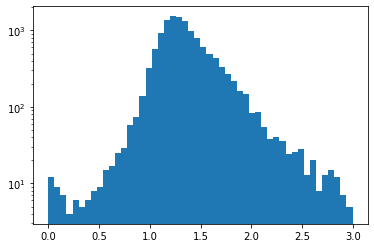

In [19]:
# plt.hist(dn4000_clean, bins=50)
plt.hist(dn4000_clean[idx_d4k_clean], bins=50)
plt.yscale('log')
plt.show()

In [20]:
luminosity = 4*np.pi*((luminosity_distance[idx_clean]/h_alpha_wl)**2)*(h_alpha_clean)

In [21]:
luminosity_cm = luminosity * mpc_to_cm

In [25]:
sfr = (7.9E-42) * luminosity_cm  # the wl correction 
print (sfr.size)
print ((h_alpha_flux[[stellar_mass==-99]]).size)

13318
13


/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
idx_uvup   = np.where(uv_class[idx_clean]=='UV_UPTURN')
idx_uvwk   = np.where(uv_class[idx_clean]=='UV_WEAK')
idx_rsf    = np.where(uv_class[idx_clean]=='RSF')
idx_redseq = np.where((nuv_band-r_band)[idx_clean]>5.4)

In [28]:
print (np.array(idx_uvup).size)
print (np.array(idx_uvwk).size)
print (np.array(idx_redseq).size)
print (np.array(idx_uvup).size+np.array(idx_uvwk).size)

209
292
501
501


### But let's separate the UV upturn objects

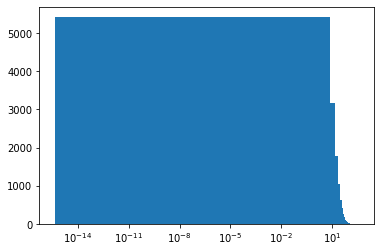

In [29]:
plt.hist(sfr, bins=50)
plt.xscale('log')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[t

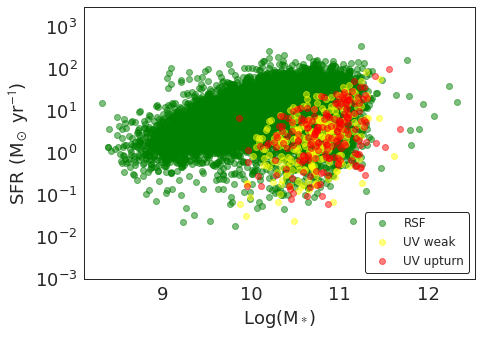

In [30]:
plt.rcParams.update(plotpars)
sns.set_style("white")
plt.semilogy(mass_clean[[uv_clean=='RSF']], sfr[[uv_clean=='RSF']], 'o', c='green', label='RSF', alpha=0.5)
plt.semilogy(mass_clean[[uv_clean=='UV_WEAK']], sfr[[uv_clean=='UV_WEAK']], 'o', color='yellow', 
             label='UV weak', alpha=0.5)
plt.semilogy(mass_clean[[uv_clean=='UV_UPTURN']], sfr[[uv_clean=='UV_UPTURN']], 'o', color='red', 
             label='UV upturn', alpha=0.5)
plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.legend(loc='best')
plt.ylim(10**(-3), )
plt.savefig('./../../Figs/g2_mass_sfr.png')
plt.show()

In [31]:
mag_abs_nuv_clean = mag_abs_nuv[idx_clean]
mag_abs_fuv_clean = mag_abs_fuv[idx_clean]
uv_color_clean = (fuv_band-nuv_band)[idx_clean]
uv_class_clean = uv_class[idx_clean]

AttributeError: 'Rectangle' object has no property 'normed'

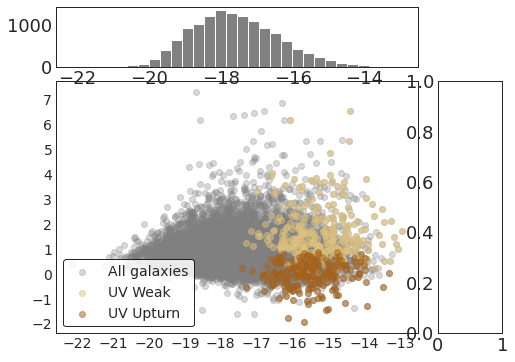

In [36]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.
      
    fig = plt.figure(figsize=(8,6))
    gs  = GridSpec(4,4, height_ratios=[2.,1.5,3.,3.], width_ratios=[3.,1.5,3.,1.5])

    ax_joint  = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    
    # Scatter plot -- MAIN PLOT ------------------------------------------------------------------------------------
    ax_joint.scatter(mag_abs_nuv_clean, uv_color_clean, c='gray', alpha=0.3, label='All galaxies')
    ax_joint.scatter(mag_abs_nuv_clean[idx_uvwk], uv_color_clean[idx_uvwk], c='#dfc27d', alpha=0.5, label='UV Weak')
    ax_joint.scatter(mag_abs_nuv_clean[idx_uvup], uv_color_clean[idx_uvup], c='#a6611a', alpha=0.5, label='UV Upturn')
    ax_joint.xaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.yaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.tick_params('both', labelsize='14')
    l1 = ax_joint.legend(loc='lower left', numpoints=1, fontsize=14, frameon=True, framealpha=0.85)
    l1.get_frame().set_edgecolor('black')
    
    # Mnuv distribution -- on the top ------------------------------------------------------------------------------
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean, color='gray', alpha=0.3, bins=30, edgecolor='black', 
                                      normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean[idx_uvwk], color='#dfc27d', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean[idx_uvup], color='#a6611a', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    ax_marg_x.tick_params('both', labelsize='14')
    ax_marg_x.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
   
    
    # FUV-NUV distribution --on the right --------------------------------------------------------------------------
    n, bins, patches = ax_marg_y.hist(uv_color_clean, orientation="horizontal", color='gray', alpha=0.3, bins=20, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvwk], orientation="horizontal", color='#dfc27d', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvup], orientation="horizontal", color='#a6611a', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    ax_marg_y.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
    ax_marg_y.tick_params(axis='x', labelsize='14')
    
    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel("M$_{NUV}$", fontsize=15)
    ax_joint.set_ylabel("FUV-NUV", fontsize=15)

    # Set labels on marginals
    ax_marg_y.set_xlabel('FUV-NUV \n frequency', fontsize=15)
    ax_marg_x.set_ylabel('M$_{NUV}$ \n frequency', fontsize=15)
    
    plt.savefig('../../Figs/g2_cmag2_uv_dist.pdf')
    plt.savefig('../../Figs/g2_cmag2_uv_dist.png')
    plt.tight_layout()
    plt.show()

AttributeError: 'Rectangle' object has no property 'normed'

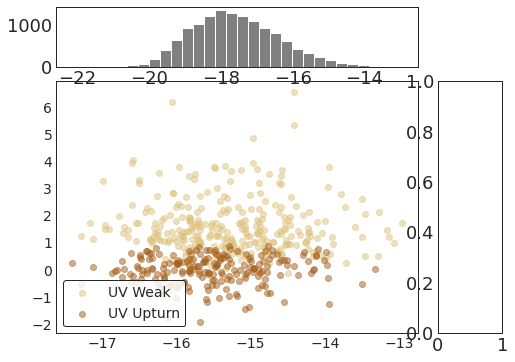

In [35]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.
      
    fig = plt.figure(figsize=(8,6))
    gs  = GridSpec(4,4, height_ratios=[2.,1.5,3.,3.], width_ratios=[3.,1.5,3.,1.5])

    ax_joint  = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    
    # Scatter plot -- MAIN PLOT ------------------------------------------------------------------------------------
#     ax_joint.scatter(mag_abs_nuv_clean, uv_color_clean, c='gray', alpha=0.3, label='All galaxies')
    ax_joint.scatter(mag_abs_nuv_clean[idx_uvwk], uv_color_clean[idx_uvwk], c='#dfc27d', alpha=0.5, label='UV Weak')
    ax_joint.scatter(mag_abs_nuv_clean[idx_uvup], uv_color_clean[idx_uvup], c='#a6611a', alpha=0.5, label='UV Upturn')
    ax_joint.xaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.yaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.tick_params('both', labelsize='14')
    l1 = ax_joint.legend(loc='lower left', numpoints=1, fontsize=14, frameon=True, framealpha=0.85)
    l1.get_frame().set_edgecolor('black')
    
    # Mnuv distribution -- on the top ------------------------------------------------------------------------------
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean, color='gray', alpha=0.0, bins=30, edgecolor='black', 
                                      normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean[idx_uvwk], color='#dfc27d', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_nuv_clean[idx_uvup], color='#a6611a', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    ax_marg_x.tick_params('both', labelsize='14')
    ax_marg_x.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
   
    
    # FUV-NUV distribution --on the right --------------------------------------------------------------------------
    n, bins, patches = ax_marg_y.hist(uv_color_clean, orientation="horizontal", color='gray', alpha=0.0, bins=20, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvwk], orientation="horizontal", color='#dfc27d', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvup], orientation="horizontal", color='#a6611a', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    ax_marg_y.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
    ax_marg_y.tick_params(axis='x', labelsize='14')
    
   # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel("M$_{NUV}$", fontsize=15)
    ax_joint.set_ylabel("FUV-NUV", fontsize=15)

    # Set labels on marginals
    ax_marg_y.set_xlabel('FUV-NUV \n frequency', fontsize=15)
    ax_marg_x.set_ylabel('M$_{NUV}$ \n frequency', fontsize=15)
    
    plt.savefig('../../Figs/g2_cmag3_uv_dist.pdf')
    plt.savefig('../../Figs/g2_cmag3_uv_dist.png')
    plt.tight_layout()
    plt.show()

AttributeError: 'Rectangle' object has no property 'normed'

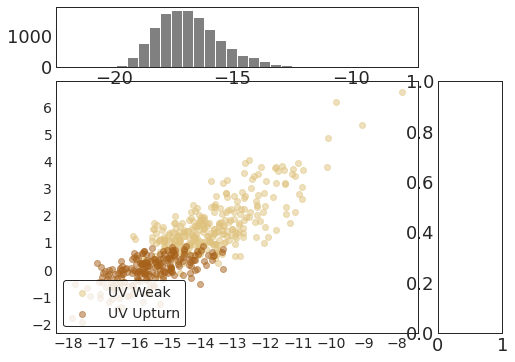

In [37]:
with plt.style.context("seaborn-white"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"] = 1.
      
    fig = plt.figure(figsize=(8,6))
    gs  = GridSpec(4,4, height_ratios=[2.,1.5,3.,3.], width_ratios=[3.,1.5,3.,1.5])

    ax_joint  = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    
    # Scatter plot -- MAIN PLOT ------------------------------------------------------------------------------------
#     ax_joint.scatter(mag_abs_fuv_clean, uv_color_clean, c='gray', alpha=0.3, label='All galaxies')
    ax_joint.scatter(mag_abs_fuv_clean[idx_uvwk], uv_color_clean[idx_uvwk], c='#dfc27d', alpha=0.5, label='UV Weak')
    ax_joint.scatter(mag_abs_fuv_clean[idx_uvup], uv_color_clean[idx_uvup], c='#a6611a', alpha=0.5, label='UV Upturn')
    ax_joint.xaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.yaxis.set_major_locator(mt.ticker.MultipleLocator(1))
    ax_joint.tick_params('both', labelsize='14')
    l1 = ax_joint.legend(loc='lower left', numpoints=1, fontsize=14, frameon=True, framealpha=0.85)
    l1.get_frame().set_edgecolor('black')
    
    # Mnuv distribution -- on the top ------------------------------------------------------------------------------
    n, bins, patches = ax_marg_x.hist(mag_abs_fuv_clean, color='gray', alpha=0.0, bins=30, edgecolor='black', 
                                      normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_fuv_clean[idx_uvwk], color='#dfc27d', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_x.hist(mag_abs_fuv_clean[idx_uvup], color='#a6611a', alpha=0.5, bins=bins, 
                                      edgecolor='black', normed=True)
    ax_marg_x.tick_params('both', labelsize='14')
    ax_marg_x.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
   
    
    # FUV-NUV distribution --on the right --------------------------------------------------------------------------
    n, bins, patches = ax_marg_y.hist(uv_color_clean, orientation="horizontal", color='gray', alpha=0.0, bins=20, 
                                      edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvwk], orientation="horizontal", color='#dfc27d', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    n, bins, patches = ax_marg_y.hist(uv_color_clean[idx_uvup], orientation="horizontal", color='#a6611a', 
                                      alpha=0.5, bins=bins, edgecolor='black', normed=True)
    ax_marg_y.yaxis.set_major_locator(mt.ticker.MultipleLocator(0.5))
    ax_marg_y.tick_params(axis='x', labelsize='14')
    
   # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel("M$_{FUV}$", fontsize=15)
    ax_joint.set_ylabel("FUV-NUV", fontsize=15)

    # Set labels on marginals
    ax_marg_y.set_xlabel('FUV-NUV \n frequency', fontsize=15)
    ax_marg_x.set_ylabel('M$_{FUV}$ \n frequency', fontsize=15)
    
    plt.savefig('../../Figs/g2_cmag4_uv_dist.pdf')
    plt.savefig('../../Figs/g2_cmag4_uv_dist.png')
    plt.tight_layout()
    plt.show()

### Redoing the above with "my" classification

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


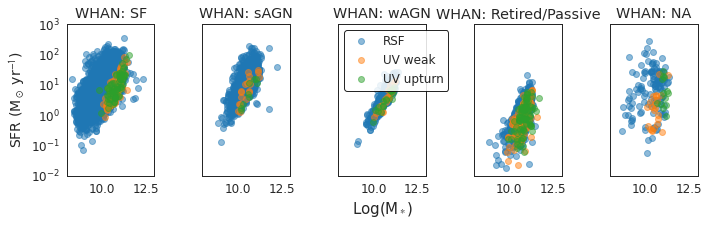

In [38]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3))

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.semilogy(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(10**(-2), 10**(3))

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2)
plt.semilogy(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(10**(-2), 10**(3))

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3)
plt.semilogy(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=15)
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(10**(-2), 10**(3))
plt.legend(loc='upper left')

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4)
plt.semilogy(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.semilogy(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(10**(-2), 10**(3))

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5)
plt.semilogy(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(10**(-2), 10**(3))

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_mass_sfr_whan.png')
plt.show()

### Other dependencies

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

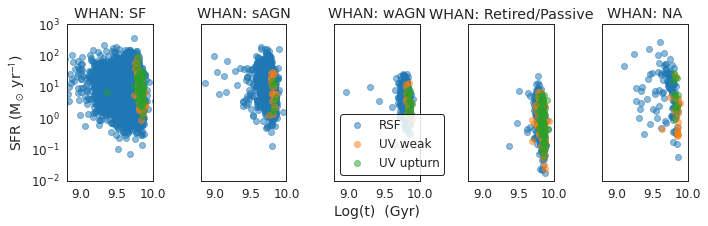

In [39]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3))

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.semilogy(stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)', fontsize='14')
plt.tick_params('both', labelsize='12')
plt.xticks([9,9.5,10])
plt.xlim(8.8,10)
plt.ylim(10**(-2), 10**(3))

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2)
plt.semilogy(stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xticks([9,9.5,10])
plt.xlim(8.8,10)
plt.ylim(10**(-2), 10**(3))

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3)
plt.semilogy(stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(t)  (Gyr)', fontsize=14)
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8.8,10)
plt.xticks([9,9.5,10])
plt.ylim(10**(-2), 10**(3))
plt.legend(loc='lower left')

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4)
plt.semilogy(stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xticks([9,9.5,10])
plt.xlim(8.8,10)
plt.ylim(10**(-2), 10**(3))

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5)
plt.semilogy(stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='RSF')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.semilogy(stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            sfr[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('SFR (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xticks([9,9.5,10])
plt.xlim(8.8,10)
plt.ylim(10**(-2), 10**(3))

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_stellar_age_sfr_whan.png')
plt.savefig('./../../Figs/g2_stellar_age_sfr_whan.pdf')
plt.show()

### Other mass dependencies

#### Dn4000

In [40]:
dn4000_clean2 = dn4000_clean[idx_d4k_clean]
mass_clean2 = mass_clean[idx_d4k_clean]
uv_clean2 = uv_clean[idx_d4k_clean]
whan_clean = whan_class[idx_clean]
whan_clean2 = whan_clean[idx_d4k_clean]

In [41]:
print (dn4000_clean2[[dn4000_clean2<0]].size)

0


/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [42]:
print (dn4000_clean.size, dn4000_clean2.size, dn4000_clean.size - dn4000_clean2.size)

13318 12944 374


/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


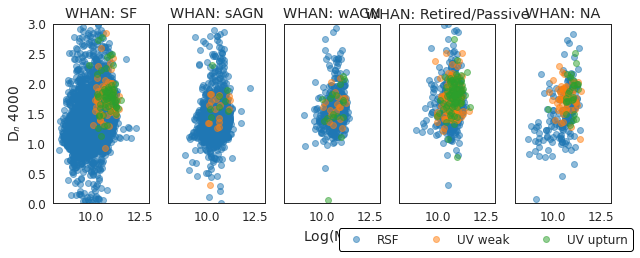

In [43]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3))

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.plot(mass_clean2[[(uv_clean2=='RSF')*(whan_clean2=='SF')]], 
            dn4000_clean2[[(uv_clean2=='RSF')*(whan_clean2=='SF')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='SF')]], 
            dn4000_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='SF')]], 
            dn4000_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('D$_n$ 4000', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(0, 3)

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2)
plt.plot(mass_clean2[[(uv_clean2=='RSF')*(whan_clean2=='sAGN')]], 
            dn4000_clean2[[(uv_clean2=='RSF')*(whan_clean2=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='sAGN')]], 
            dn4000_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='sAGN')]], 
            dn4000_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('D$_n$ 4000', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(0, 3)

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3)
plt.plot(mass_clean2[[(uv_clean2=='RSF')*(whan_clean2=='wAGN')]], 
            dn4000_clean2[[(uv_clean2=='RSF')*(whan_clean2=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='wAGN')]], 
            dn4000_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='wAGN')]], 
            dn4000_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=14)
plt.ylabel('D$_n$ 4000', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(0, 3)
ax03.legend(loc='lower center', bbox_to_anchor=(2.1, -0.3), fontsize=12, frameon=True, framealpha=1., ncol=3)

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4)
plt.plot(mass_clean2[[(uv_clean2=='RSF')*(whan_clean2=='Retired/Passive')]], 
            dn4000_clean2[[(uv_clean2=='RSF')*(whan_clean2=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='Retired/Passive')]], 
            dn4000_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.plot(mass_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='Retired/Passive')]], 
            dn4000_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('D$_n$ 4000', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(0, 3)

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5)
plt.plot(mass_clean2[[(uv_clean2=='RSF')*(whan_clean2=='NA')]], 
            dn4000_clean2[[(uv_clean2=='RSF')*(whan_clean2=='NA')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='NA')]], 
            dn4000_clean2[[(uv_clean2=='UV_WEAK')*(whan_clean2=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='NA')]], 
            dn4000_clean2[[(uv_clean2=='UV_UPTURN')*(whan_clean2=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
plt.ylabel('D$_n$ 4000', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(0, 3)

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_mass_dn4000_whan.png')
plt.savefig('./../../Figs/g2_mass_dn4000_whan.pdf')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


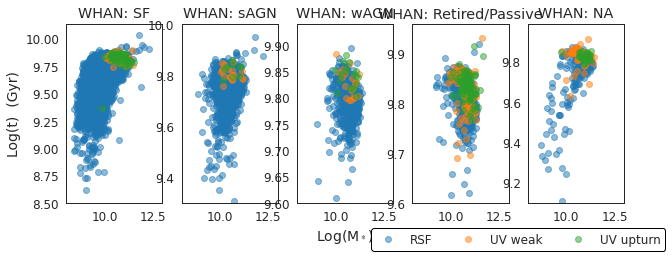

In [44]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3))

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(8.5,)

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
# ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(9.3,)

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
# ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=14)
# plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(9.6, )
ax03.legend(loc='lower center', bbox_to_anchor=(2.3, -0.3), fontsize=12, frameon=True, framealpha=1., ncol=3)

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
# ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(9.6,)

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
# ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
plt.ylim(9.1, )

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_mass_stellar_age_whan_01.png')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

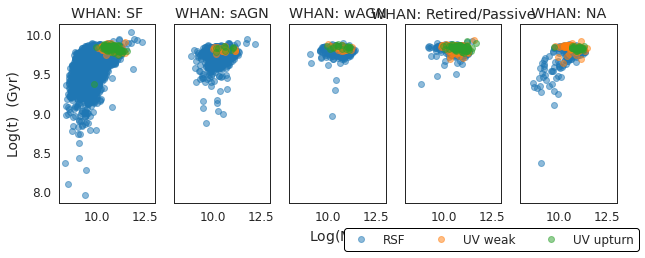

In [45]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3), sharey=True)

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(8.5,)

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.3,)

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=14)
# plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.6, )
ax03.legend(loc='lower center', bbox_to_anchor=(2.1, -0.3), fontsize=12, frameon=True, framealpha=1., ncol=3)

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.6,)

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_age_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.1, )

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_mass_stellar_age_whan_02.png')
plt.show()

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

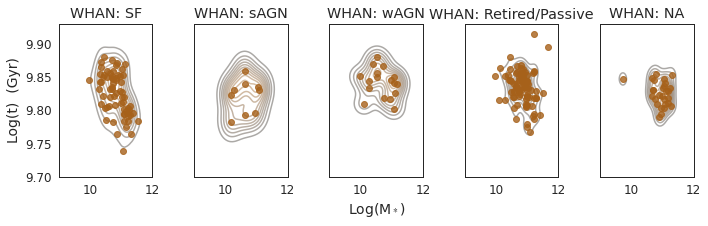

In [46]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3), sharey=True)

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
        stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o',  color='#a6611a',
         alpha=0.8, label='UV upturn')
sns.kdeplot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]],
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], color='#a6611a',
            alpha=0.4, label='UV upturn')
plt.title("WHAN: SF")
plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(9, 12)
plt.ylim(9.70, 9.93)

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
        stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', color='#a6611a',
         alpha=0.8, label='UV upturn')
sns.kdeplot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]],
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], color='#a6611a',
            alpha=0.4, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
plt.tick_params('both', labelsize='12')
plt.xlim(9, 12)
plt.ylim(9.70, 9.93)

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
        stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', color='#a6611a', 
         alpha=0.8, label='UV upturn')
sns.kdeplot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]],
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], color='#a6611a',
            alpha=0.4, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(9, 12)
plt.ylim(9.70, 9.93)
# ax03.legend(loc='lower center', bbox_to_anchor=(2.1, -0.3), fontsize=12, frameon=True, framealpha=0.8, ncol=1)

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]],
         stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o',  
         color='#a6611a', alpha=0.8,label='UV upturn')
sns.kdeplot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]],
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            color='#a6611a',alpha=0.4, label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
plt.tick_params('both', labelsize='12')
plt.xlim(9, 12)
plt.ylim(9.70, 9.93)

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
         stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', color='#a6611a', 
         alpha=0.8, label='UV upturn')
sns.kdeplot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]],
            stellar_age_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            color='#a6611a',alpha=0.4, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
plt.tick_params('both', labelsize='12')
plt.xlim(9, 12)
plt.ylim(9.70, 9.93)

plt.tight_layout(w_pad=0.0)
plt.savefig('./../../Figs/g2_mass_stellar_age_whan_uvup.png')
plt.show()

In [47]:
print stellar_age_clean[[(uv_clean=='UV_UPTURN')]].max()
print stellar_age_clean[[(uv_clean=='UV_UPTURN')]].min()

SyntaxError: invalid syntax (<ipython-input-47-49ebbd644807>, line 1)

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whic

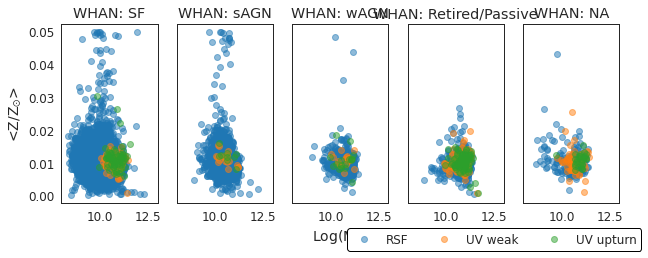

In [49]:
sns.set_style("white")
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.
plt.subplots(1,1, figsize=(10,3.3), sharey=True)

# WHAN SF CLASS ------------------
ax01 = plt.subplot(1,5,1)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 
            stellar_met_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 
            stellar_met_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 
            stellar_met_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='SF')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: SF")
# plt.xlabel('Log(M$_*$)')
plt.ylabel('<Z/Z$_{\odot}$>', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(8.5,)

# WHAN sAGN CLASS ------------------
ax02 = plt.subplot(1,5,2, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_met_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_met_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 
            stellar_met_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='sAGN')]], 'o', alpha=0.5, label='UV upturn')
ax02.yaxis.set_visible(False)
plt.title("WHAN: sAGN")
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_met_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.3,)

# WHAN wAGN CLASS ------------------
ax03= plt.subplot(1,5,3, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_met_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_met_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 
            stellar_met_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='wAGN')]], 'o', alpha=0.5, label='UV upturn')
ax03.yaxis.set_visible(False)
plt.title("WHAN: wAGN")
plt.xlabel('Log(M$_*$)', fontsize=14)
# plt.ylabel('Log(t)  (Gyr)', fontsize=14)
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.6, )
ax03.legend(loc='lower center', bbox_to_anchor=(2.1, -0.3), fontsize=12, frameon=True, framealpha=1., ncol=3)

# WHAN Retired/Passive CLASS ------------------
ax04 = plt.subplot(1,5,4, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_met_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_met_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 
            stellar_met_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]], 'o', alpha=0.5, 
             label='UV upturn')
plt.title("WHAN: Retired/Passive")
ax04.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_met_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.6,)

# WHAN NA CLASS (unclassified) ------------------
ax05 = plt.subplot(1,5,5, sharey=ax01)
plt.plot(mass_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 
            stellar_met_clean[[(uv_clean=='RSF')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='RSF')
plt.plot(mass_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 
            stellar_met_clean[[(uv_clean=='UV_WEAK')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV weak')
plt.plot(mass_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
            stellar_met_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 'o', alpha=0.5, label='UV upturn')
plt.title("WHAN: NA")
ax05.yaxis.set_visible(False)
# plt.xlabel('Log(M$_*$)')
# plt.ylabel('stellar_met_clean (M$_\odot$ yr$^{-1}$)')
plt.tick_params('both', labelsize='12')
plt.xlim(8, 13)
# plt.ylim(9.1, )

# plt.tight_layout(w_pad=0.0)
plt.tight_layout()
plt.savefig('./../../Figs/g2_mass_stellar_met_whan.png')
plt.show()

In [50]:
cataid_clean = cataid[idx_clean]
objdr7_clean = my_dictionary['OBJID_SDSSDR7'][idx_clean]

In [51]:
print cataid_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]], 
cataid_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]].size

SyntaxError: invalid syntax (<ipython-input-51-524ccae077fc>, line 1)

In [52]:
print objdr7_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]],
objdr7_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]].size

SyntaxError: invalid syntax (<ipython-input-52-cbf501c4569f>, line 1)

In [53]:
spec_i_need = {}
spec_i_need['CATAID'] = cataid_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]]
spec_i_need['OBJID_SDSSDR7'] = objdr7_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='NA')]]

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
cataid_uvup_rp = cataid_clean[[(uv_clean=='UV_UPTURN')*(whan_class[idx_clean]=='Retired/Passive')]]

/home/mlldantas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


In [55]:
print cataid_uvup_rp.size
for i in range(cataid_uvup_rp.size):
    print cataid_uvup_rp[i] 

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(cataid_uvup_rp.size)? (<ipython-input-55-e58e5ead1d2a>, line 1)

In [56]:
spec_i_need = pd.DataFrame(spec_i_need)

In [57]:
spec_i_need.to_csv('./spec.csv', index=False)

In [58]:
spec_i_need

,CATAID,OBJID_SDSSDR7
0,598961,588848900427481399
1,611468,588848900451729571
2,301850,587726032229040530
3,321414,587726032267378887
4,373305,587727942956024011
5,375789,587727943488635247
6,376042,587727943489094234
7,423115,587728879794585926
8,3604402,587729150911971799
9,3613123,587729150914134215
